In [173]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
from hierarchSIR.utils import get_NC_influenza_data
from scipy.stats import zscore
from scipy.interpolate import UnivariateSpline

## Leave-one-out analysis

### Load data

In [378]:
accuracy = pd.read_csv('accuracy.csv', parse_dates=True)

### Compute periods where curvature exceeds some threshold

In [ ]:
def find_non_exponential_points(idx, y_smooth, threshold=0.003, c=1e-3):
    """
    Identify points where epidemic growth deviates from exponential behavior.
    """

    # add small constant to avoid log(0)
    y_log = np.log(y_smooth + c)

    # compute 1st and 2nd derivatives in log-space
    dy_log = np.gradient(y_log)
    d2y_log = np.gradient(dy_log)

    # curvature magnitude in log-space
    curvature = d2y_log # np.abs(d2y_log)

    # apply threshold
    pos_curvature_idx = idx[(curvature >= threshold)]
    neg_curvature_idx = idx[(curvature <= -threshold)]

    return pos_curvature_idx, neg_curvature_idx,
    

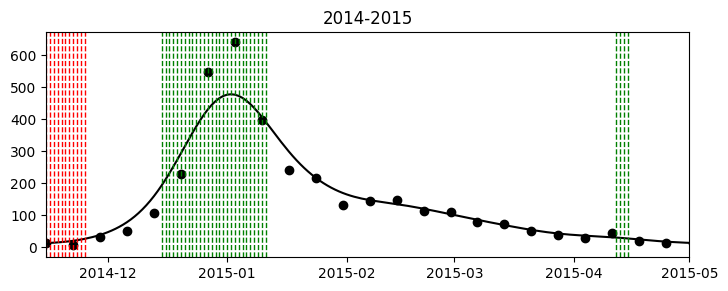

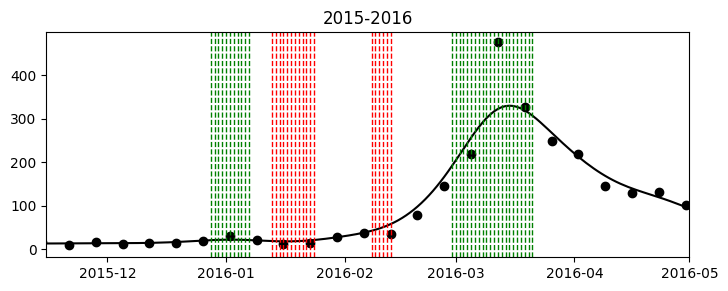

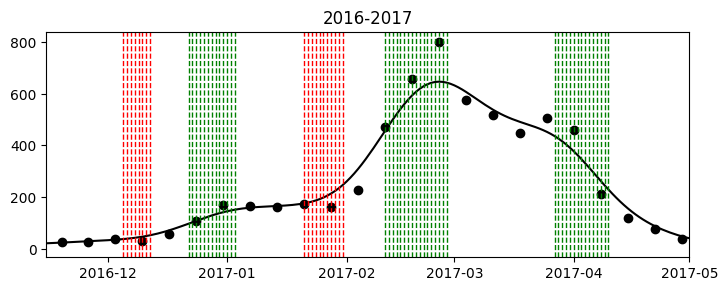

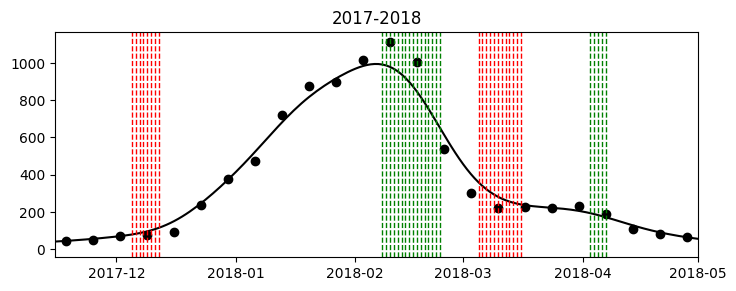

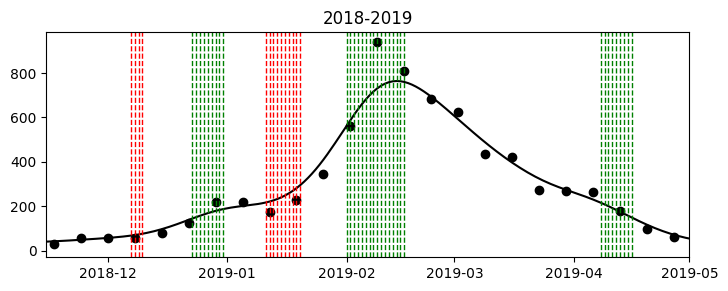

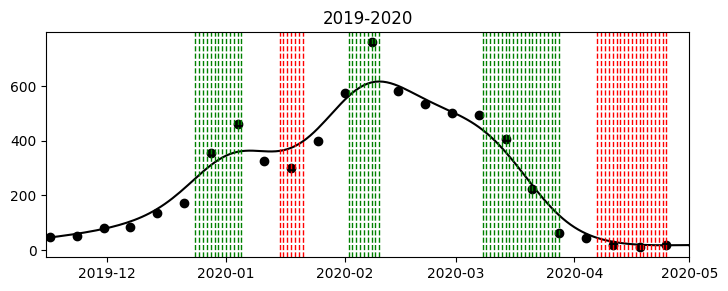

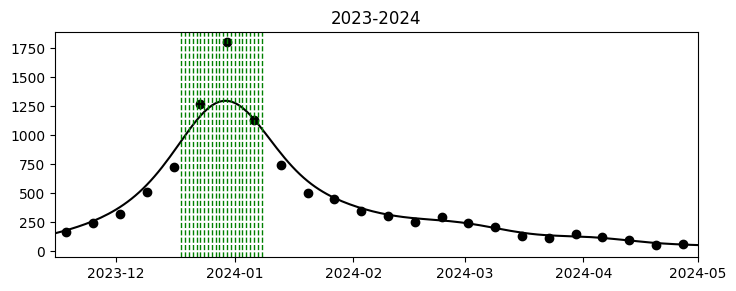

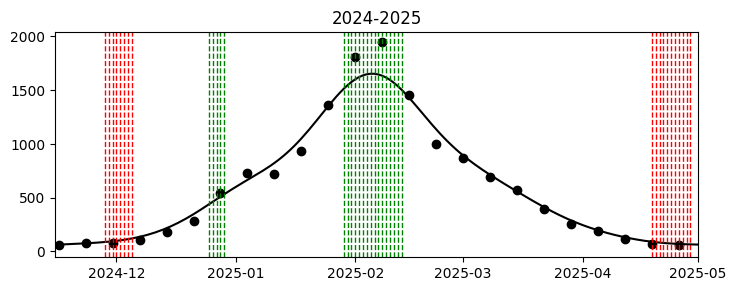

In [413]:
num_blocks_save = []
seasons = ['2014-2015', '2015-2016', '2016-2017', '2017-2018', '2018-2019', '2019-2020', '2023-2024', '2024-2025']
for season in seasons:
    # get data
    df = 7*get_NC_influenza_data(datetime(int(season[0:4]), 10, 15), datetime(int(season[0:4])+1, 6, 1), season)['H_inc'].to_frame()
    # expand to daily
    df_daily = df.resample('D').interpolate(method='linear')
    # smooth data
    df_daily['H_inc_smooth'] = gaussian_filter1d(df_daily['H_inc'], sigma=8)
    # find inflection points
    idx_pos, idx_neg = find_non_exponential_points(df_daily.index, df_daily['H_inc_smooth'], threshold=0.0025)
    # plot results
    fig, ax = plt.subplots(figsize=(8.3, 11.7/4))
    ax.scatter(df.index, df['H_inc'], marker='o', color='black', label='Weekly (z-scored)')
    ax.plot(df_daily.index, df_daily['H_inc_smooth'], linewidth=1.5, color='black', label='Smoothed daily (Gaussian)')
    for i in idx_pos:
        ax.axvline(i, linewidth=1, linestyle='--', color='red')
    for i in idx_neg:
        ax.axvline(i, linewidth=1, linestyle='--', color='green')
    ax.set_title(f'{season}')
    ax.set_xlim([datetime(int(season[0:4]), 11, 15), datetime(int(season[0:4])+1, 5, 1) ])
    plt.show()
    plt.close()
    # compute number of contiguous blocks
    ## positive
    idx_pos = idx_pos[((idx_pos >= datetime(int(season[0:4]), 11, 15)) & (idx_pos <= datetime(int(season[0:4])+1, 5, 1)))]
    if len(idx_pos) == 0:
        num_blocks = 0
    else:
        diff = idx_pos.to_series().diff()
        num_blocks = (diff > pd.Timedelta(days=1)).sum() + 1
    ## negative 
    idx_neg = idx_neg[((idx_neg >= datetime(int(season[0:4]), 11, 15)) & (idx_neg <= datetime(int(season[0:4])+1, 5, 1)))]
    diff = idx_neg.to_series().diff()
    num_blocks += (diff > pd.Timedelta(days=1)).sum() + 1
    num_blocks_save.append(num_blocks)
output = pd.Series(index=seasons, data=num_blocks_save, name='large_curvature_regions')

In [400]:
output

2014-2015    3
2015-2016    4
2016-2017    5
2017-2018    4
2018-2019    5
2019-2020    5
2023-2024    1
2024-2025    4
Name: large_curvature_regions, dtype: int64

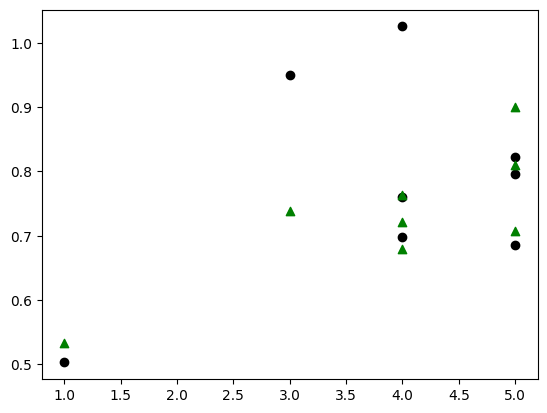

In [412]:
# perform analysis for IL = False and ED_visits = True
slice = accuracy[((accuracy['informed'] == True) & (accuracy['immunity_linking'] == False) & (accuracy['ED_visits'] == True))][['model', 'season', 'relative_WIS_drift']]
from scipy.stats import gmean
# group by model and season, then compute geometric mean
gmean_slice = slice.groupby(['model', 'season'])['relative_WIS_drift'].apply(gmean).reset_index()
gmean_slice['num_blocks'] = gmean_slice['season'].map(output)

fig,ax=plt.subplots()
ax.scatter(gmean_slice[gmean_slice['model'] == 'SIR-1S']['num_blocks'], gmean_slice[gmean_slice['model'] == 'SIR-1S']['relative_WIS_drift'], marker='o', color='black')
#ax.scatter(gmean_slice[gmean_slice['model'] == 'SIR-2S']['num_blocks'], gmean_slice[gmean_slice['model'] == 'SIR-2S']['relative_WIS_drift'], marker='s', color='red')
ax.scatter(gmean_slice[gmean_slice['model'] == 'SIR-3S']['num_blocks'], gmean_slice[gmean_slice['model'] == 'SIR-3S']['relative_WIS_drift'], marker='^', color='green')
plt.show()
plt.close()
